In [1]:
import os
from io import BytesIO
import lmdb
from PIL import Image
import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torch.distributions.uniform import Uniform
from torchvision.utils import make_grid
from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

In [2]:
class AnimeFace(Dataset):
    def __init__(
        self, 
        root_folder='/amax/data/LHao/dataset/', 
        transform=None, 
        sizes=(4, 8, 16, 32, 64), 
        db_path='./lmdb_data', 
        resolution=64
    ):
        super().__init__()
        self.sizes = sizes
        self.resolution = resolution
        imgs = ImageFolder(root_folder)
        self._save_db(imgs, db_path)
        self._db = lmdb.open(db_path)
        self.transform = transform
        
    def _save_db(self, files, db_path):
        img_count = 0
        db = lmdb.open(db_path, map_size=1024 ** 4)
        with db.begin(write=True) as file:
            for i, (original_img, _) in enumerate(files.imgs):
                resize_imgs = self._resize_resolution(original_img)
                for size, img in zip(self.sizes, resize_imgs):
                    key = f'{size}-{str(i).zfill(5)}'
                    file.put(key.encode('utf-8'), img)
                img_count += 1
            file.put('length'.encode('utf-8'), str(img_count).encode('utf-8'))
            self._length = img_count
        db.close()
        
    def _resize_resolution(self, img):
        imgs = []
        img = Image.open(img)
        for size in self.sizes:
            buffer = BytesIO()
            img_resize = transforms.F.resize(img, size)
            img_resize = transforms.F.center_crop(img_resize, size)
            img_resize.save(buffer, format='jpeg')
            imgs.append(buffer.getvalue())
        return imgs
                
    def __len__(self):
        return self._length
    
    def __getitem__(self, index):
        with self._db.begin(write=False) as file:
            img_bytes = file.get(f'{self.resolution}-{str(index).zfill(5)}'.encode())
        buffer = BytesIO(img_bytes)
        img = Image.open(buffer)
        if self.transform:
            img = self.transform(img)
        return img
    
    def __del__(self):
        self._db.close()
        
    def show(self, index):
        plt.imshow(self[index].permute(1, 2, 0))

In [9]:
writer = SummaryWriter('./runs')

## 工具类

In [3]:
class PixelwiseNorm(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the module
        :param x: input activations volume
        :param alpha: small number for numerical stability
        :return: y => pixel normalized activations
        """
        y = x.pow(2.).mean(dim=1, keepdim=True).add(alpha).sqrt()  # [N1HW]
        y = x / y  # normalize the input x volume
        return y
    
class FadeIn():
    def __init__(self):
        self.alpha = 1e-5
        
    def __call__(self, x, y):
        return x * (1 - self.alpha) + y * self.alpha
    
    def _update_alpha(self, delta):
        self.alpha += abs(delta)
        self.alpha = float(min(self.alpha, 1.))
        
    def _reset(self):
        self.alpha = 1e-5
        
class MinibatchStdDev(nn.Module):
    """
    Minibatch standard deviation layer for the discriminator
    """
    def __init__(self):
        """
        derived class constructor
        """
        super().__init__()

    def forward(self, x, alpha=1e-8):
        """
        forward pass of the layer
        :param x: input activation volume
        :param alpha: small number for numerical stability
        :return: y => x appended with standard deviation constant map
        """
        batch_size, _, height, width = x.shape

        # [B x C x H x W] Subtract mean over batch.
        y = x - x.mean(dim=0, keepdim=True)

        # [1 x C x H x W]  Calc standard deviation over batch
        y = torch.sqrt(y.pow(2.).mean(dim=0, keepdim=False) + alpha)

        # [1]  Take average over feature_maps and pixels.
        y = y.mean().view(1, 1, 1, 1)

        # [B x 1 x H x W]  Replicate over group and pixels.
        y = y.repeat(batch_size, 1, height, width)

        # [B x C x H x W]  Append as new feature_map.
        y = torch.cat([x, y], 1)

        # return the computed values:
        return y

In [4]:
class Generator(nn.Module):
    def __init__(self, in_channels=512):
        '''
        :param in_channels: 输入隐向量的维度
        :param level : 生成图片的大小，4x4：1; 8x8: 2; 16x16：3
        '''
        super().__init__()
        self.in_channels = in_channels
        self.temp_layer = None
        self.residual_to_rgb = self._to_rgb(in_channels)
        self.residual_to_rgb.apply(self._init_weight)
        self.x_to_rgb = self._to_rgb(in_channels)
        self.x_to_rgb.apply(self._init_weight)
        self.fade_in = FadeIn()
        self.model = nn.Sequential(
            self._first_block(in_channels=in_channels, out_channels=512),
        )
        self.model.apply(self._init_weight)
    
    def forward(self, x, level, alpha):
        x = self.model(x)
        if level == 1:
            return self.x_to_rgb(x)
        else:
            residual = F.interpolate(x, scale_factor=2)
            residual = self.residual_to_rgb(residual)
            
            x = self.temp_layer(x)
            x = self.x_to_rgb(x)
            self.fade_in.alpha = alpha
            return self.fade_in(residual, x)
            
    
    def _first_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels=in_channels, out_channels=in_channels, kernel_size=4),
            nn.LeakyReLU(0.2),
            PixelwiseNorm(),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            PixelwiseNorm()
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.LeakyReLU(0.2),
            PixelwiseNorm(),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.LeakyReLU(0.2),
            PixelwiseNorm()
        )
    
    
    def _to_rgb(self, in_channels):
        return nn.Conv2d(in_channels, 3, 1)
        
    
    def add_level(self, level):
        if level == 2:
            self._update_layer(self.in_channels, self.in_channels)
        elif 2 < level <=4:
            self.fade_in._reset()
            self.model.add_module(f'res{2**level}', self.temp_layer)
            self._update_layer(self.in_channels, self.in_channels)
        elif level > 4:
            self.fade_in._reset()
            self.model.add_module(f'res{2**level}', self.temp_layer)
            in_channels = int(self.in_channels // np.power(2, level - 5))
            out_channels = int(self.in_channels // np.power(2, level - 4))
            self._update_layer(in_channels, out_channels)
        
    def _update_layer(self, in_channels, out_channels):
        self.temp_layer = self._block(in_channels, out_channels, 3, 1, 1)
        self.temp_layer.apply(self._init_weight)
        self.residual_to_rgb = self._to_rgb(in_channels)
        self.residual_to_rgb.apply(self._init_weight)
        self.x_to_rgb = self._to_rgb(out_channels)
        self.x_to_rgb.apply(self._init_weight)
        
        
    def _init_weight(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.kaiming_normal_(m.weight.data)
#         if isinstance(m, nn.BatchNorm2d):
#             nn.init.normal_(m.weight.data, 0, 0.05)
#             nn.init.constant_(m.bias.data, 0)

            
class Discriminator(nn.Module):
    def __init__(self, in_channels=512):
        super().__init__()
        self.in_channels = in_channels
        self.temp_layer = None
        self.residual_from_rgb = self._from_rgb(out_channels=512)
        self.residual_from_rgb.apply(self._init_weight)
        self.x_from_rgb = self._from_rgb(out_channels=512)
        self.x_from_rgb.apply(self._init_weight)

        self.fade_in = FadeIn()
        
        self.model = nn.ModuleList([
            self._final_block(in_channels=512, out_channels=1),
        ])
        self.model.apply(self._init_weight)
    
    def forward(self, x, level, alpha):
        residual = x.clone()
        x = self.x_from_rgb(x)
        if level == 1:
            for m in self.model:
                x = m(x)
            return x.view(-1)
        else:
            residual = F.avg_pool2d(residual, kernel_size=2, stride=2)
            residual = self.residual_from_rgb(residual)
#             x = self.temp_from_rgb(x)
            x = self.temp_layer(x)
            self.fade_in.alpha = alpha
            x = self.fade_in(residual, x)
            for m in self.model:
                x = m(x)
            return x.view(-1)

    
    def _final_block(self, in_channels, out_channels):
        return nn.Sequential(
            MinibatchStdDev(),
            nn.Conv2d(in_channels=in_channels+1, out_channels=in_channels, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=in_channels, out_channels=in_channels, kernel_size=4, stride=1, padding=0),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=512, out_channels=1, kernel_size=1)
        )
    
    def _block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.LeakyReLU(0.2),
            nn.AvgPool2d(2)
        )

    def _from_rgb(self, out_channels):
        return nn.Conv2d(3, out_channels=out_channels, kernel_size=1)
    
    def _init_weight(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.kaiming_normal_(m.weight.data)
            
            
    def add_level(self, level):
        if level == 2:
            self._update_layer(self.in_channels, self.in_channels)
        elif 2 < level <= 4:
            self.fade_in._reset()
            self.model.insert(0, self.temp_layer)
            self._update_layer(self.in_channels, self.in_channels)
        elif level > 4:
            self.fade_in._reset()
            self.model.insert(0, self.temp_layer)
            in_channels = int(self.in_channels // np.power(2, level - 4))
            out_channels = int(self.in_channels // np.power(2, level - 5))
            self._update_layer(in_channels, out_channels)
            
    def _update_layer(self, in_channels, out_channels):
        self.temp_layer = self._block(in_channels, out_channels, 3, 1, 1)
        self.temp_layer.apply(self._init_weight)
        self.residual_from_rgb = self._from_rgb(out_channels)
        self.residual_from_rgb.apply(self._init_weight)
        self.x_from_rgb = self._from_rgb(in_channels)
        self.x_from_rgb.apply(self._init_weight)

In [5]:
gen = Generator(in_channels=512)
dis = Discriminator()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen.to(device)
dis.to(device)

ngpu = 2
IS_PARALLEL = True if ngpu > 1 else False
nz = 512
num_epochs = 20
batch_size = 64
# fixed_noise = torch.randn(32, nz, 1, 1, device=device)

real_idx = 1
fake_idx = 0

if IS_PARALLEL and torch.cuda.device_count() > 1:
    gen = nn.DataParallel(gen)
    dis = nn.DataParallel(dis)
    
# criterion = nn.BCELoss()
# criterion.to(device)

beta1 = 0.5
gen_optimizer = torch.optim.Adam(gen.parameters(), lr=0.0002, betas=(beta1, 0.999))
dis_optimizer = torch.optim.Adam(dis.parameters(), lr=0.0002, betas=(beta1, 0.999))

lr_scheduler_g = torch.optim.lr_scheduler.StepLR(gen_optimizer, step_size=3, gamma=0.1)
lr_scheduler_d = torch.optim.lr_scheduler.StepLR(dis_optimizer, step_size=3, gamma=0.1)  # 每set_size个epoch更新一次学习率

In [6]:
image_transforms = transforms.Compose(
    [
#         transforms.Resize(64),
#         transforms.CenterCrop(64),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)
dataset = AnimeFace(root_folder='/amax/data/LHao/dataset/', transform=image_transforms)
# train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [7]:
import sys

sizes = (4, 8, 16, 32, 64)
for level, size in enumerate(sizes, start=1):
    dataset.resolution = 2 ** (level + 1)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    print(f'res: {dataset.resolution} x {dataset.resolution}')
    alpha = 1e-5
    for data in train_loader:
        bz = data.size(0)
        z = torch.randn(bz, nz, 1, 1, device=device)
        dis_loss, gen_loss = 0, 0

#         real_label = Uniform(0.9, 1.0).sample((bz,)).to(device)
#         fake_label = Uniform(0., 0.1).sample((bz,)).to(device)

        real_sample = data.to(device)
        fake_sample = gen(z, level=level, alpha=alpha)

        dis.zero_grad()

        real_predict = dis(real_sample, level=level, alpha=alpha)
        real_predict = real_predict.mean() - 0.001 * (real_predict ** 2).mean()
        (-real_predict).backward()

        fake_predict = dis(fake_sample, level=level, alpha=alpha)
        fake_predict = fake_predict.mean()
        fake_predict.backward()

        eps = torch.rand(bz, 1, 1, 1).cuda()
        x_hat = eps * real_sample.data + (1 - eps) * fake_sample.data
        x_hat.requires_grad = True
        hat_predict = dis(x_hat, level=level, alpha=alpha)
        grad_x_hat = torch.autograd.grad(
            outputs=hat_predict.sum(), inputs=x_hat, create_graph=True
        )[0]
        grad_penalty = (
            (grad_x_hat.view(grad_x_hat.size(0), -1).norm(2, dim=1) - 1) ** 2
        ).mean()
        grad_penalty = 10 * grad_penalty
        grad_penalty.backward()
        grad_loss = grad_penalty.item()
        disc_loss = (-real_predict + fake_predict).item()

        dis_optimizer.step()


        gen.zero_grad()
        z = torch.randn(bz, nz, 1, 1, device=device)
        fake_sample = gen(z, level=level, alpha=alpha)
        predict = dis(fake_sample, level=level, alpha=alpha)
        loss = -predict.mean()
        gen_loss = loss.item()

        loss.backward()
        gen_optimizer.step()
        
        alpha += 0.04
        alpha = min(1, alpha)
#         sys.exit()
        
    gen.module.add_level(level + 1)
    dis.module.add_level(level + 1)
    gen.module.to(device)
    dis.module.to(device)

res: 4 x 4
res: 8 x 8
res: 16 x 16
res: 32 x 32
res: 64 x 64


In [12]:
output = gen(z, level=5, alpha=0)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


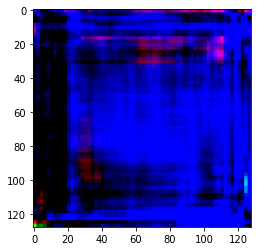

In [20]:
plt.imshow(output[0].permute(1,2,0).cpu().detach().numpy())